In [ ]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf                        
import matplotlib.pyplot as plt      
from mpl_toolkits import mplot3d
import os
import sys
import glob
import time
import shutil
from tensorflow.keras import layers
import gym
from gym import error, spaces, utils
import numpy as np
import math

In [ ]:
import gym_fish

In [ ]:
from gym_fish.envs.lib import pyflare as fl

In [ ]:
Experiment_name = 'budgeted reward with pretrain 3e-4'
# Experiment_name = 'test NaN PPO2'
Experiment_note = "budgeted reward with pretrain"

### Import Settings

In [ ]:
cwd = '/home/liuwj/PycharmProjects/testPylib/rl_test/'
data_folder =cwd+ 'py_data/'
json_folder =data_folder+'jsons/'
path_folder =json_folder+'paths/'
scripts_folder = cwd+'scripts/'

In [ ]:
sys.path.append(cwd)

In [ ]:
fluid_json = json_folder+'fluid_param_short.json'
rigid_json = json_folder+'rigids.json'
path_jsons = sorted(glob.glob(path_folder+'line.json'))

In [ ]:
def plot_infos(infos,title,reward_fig_name):
    dd = {k:[] for k in infos[0].keys()}
    for info in infos:
        for k in info.keys():
            dd[k].append(info[k])
    plt.figure()
    for k in dd.keys():
        if k=='action_penality':
            plt.plot(np.arange(0,len(dd[k])),[kkk  for kkk in dd[k]],label=k)
        else:
            plt.plot(np.arange(0,len(dd[k])),dd[k],label=k)
    plt.legend()
    plt.title(title)
    plt.savefig(reward_fig_name)
    plt.show()

### Output Settings

In [9]:
store_folder_name = Experiment_name+'_'+time.strftime('%Y-%m-%d %H:%M/',time.localtime(time.time()))
imgs_folder_name = 'imgs/'
rl_data_folder_name = 'rl_data/'
rl_data_all_name='collected_o_a.npz'
network_folder_name = 'networks/'
store_folder = cwd+'output_data/'+store_folder_name
imgs_folder = store_folder+imgs_folder_name
rl_data_folder= store_folder+rl_data_folder_name
network_folder = store_folder+network_folder_name

if not os.path.exists(store_folder):
    os.makedirs(store_folder)
if not os.path.exists(imgs_folder):
    os.makedirs(imgs_folder)
if not os.path.exists(rl_data_folder):
    os.makedirs(rl_data_folder)
if not os.path.exists(network_folder):
    os.makedirs(network_folder)

## Saving sources

In [10]:
save_sources = True
sources_folder_name = ['py_data','scripts']
if save_sources==True:
    for fn in sources_folder_name:
        shutil.copytree(cwd+fn,store_folder+'sources/'+fn)
with open(store_folder+'note.txt','w+') as f:
    f.write(time.strftime('%Y-%m-%d %H:%M\n',time.localtime(time.time())))
    f.write(Experiment_note)

### Runtime Argument Setttings

In [ ]:
init_vel = 0 
commonForce = 20
baseTailFreq = 2
Kp = 10
Kd = 2


### Start Collecting Data

In [ ]:
import gym_fish
from gym_fish.envs.lib import pyflare as fl
def collect_ob_ac(path_json,fluid_json,rigid_json,n_episodes=1):
    env=gym.make('fish-v0',path_json=path_json, rigid_json=rigid_json, fluid_json=fluid_json)
    
    orientation_pd_control = fl.PDControl1D(Kp, Kd, env.rigid_data.rigidWorld.getTimestep())
    actions = []
    observations = []
    rewards = []
    infos = []
    episode_returns = np.zeros((n_episodes,))
    episode_starts = []
    
    ep_idx = 0
    obs = env.reset()
    episode_starts.append(True)
    reward_sum = 0.0
    idx = 0
    # state and mask for recurrent policies
    state, mask = None, None
    
    
    while ep_idx < n_episodes:
        observations.append(obs)
        
        pos  = env.rigid_data.skeletons[0].dynamics.getBaseLink().getPosition()
        pose = env.path_data.trajectory.getPose(env.curPose_t+0.05)
        fwd = env.rigid_data.skeletons[0].dynamics.getBaseLinkFwd()
        right = env.rigid_data.skeletons[0].dynamics.getBaseLinkRight()
        expected_fwd =pose.getPosition() - pos
        expected_fwd = expected_fwd/np.linalg.norm( expected_fwd)
        vec_fwd2expected = expected_fwd - (fwd.dot(expected_fwd)) * fwd
        vec_error = vec_fwd2expected.dot(right)
        action = -orientation_pd_control.feedback(vec_error, env.rigid_data.rigidWorld.getTimestep())+20 * math.cos(2*env.rigid_data.rigidWorld.time *2*math.pi)
#         action = -orientation_pd_control.feedback(vec_error, env.rigid_data.rigidWorld.getTimestep())
        action = env._normalize_action(action)
#         if env.rigid_data.rigidWorld.time<5:
#             action = env._normalize_action(action)
#         else:
#             action=0
        obs, reward, done, info = env.step(action)
        infos.append(info)
        actions.append(action)
        rewards.append(reward)
        episode_starts.append(done)
        reward_sum += reward
        idx += 1
        if done:
            print(env.cur_budget)
            env.plot3d(title = 'path{0}_initvel_{1}_time{2}'.format(0,init_vel,env.rigid_data.rigidWorld.time),
            fig_name=imgs_folder+'path{0}_initvel_{1}_time{2}.png'.format(0,init_vel,env.rigid_data.rigidWorld.time))
            print("using simulated time : ",env.rigid_data.rigidWorld.time)
            print("Iters : ",env.simulator.getIterNum())
            orientation_pd_control.reset()
            obs = env.reset()
            # Reset the state in case of a recurrent policy
            state = None
            episode_returns[ep_idx] = reward_sum
            reward_sum = 0.0
            ep_idx += 1
            
    if isinstance(env.observation_space, spaces.Box):
        observations = np.concatenate(observations).reshape((-1,) + env.observation_space.shape)
    elif isinstance(env.observation_space, spaces.Discrete):
        observations = np.array(observations).reshape((-1, 1))
    if isinstance(env.action_space, spaces.Box):
        actions = np.concatenate(actions).reshape((-1,) + env.action_space.shape)
    elif isinstance(env.action_space, spaces.Discrete):
        actions = np.array(actions).reshape((-1, 1))
    rewards = np.array(rewards)
    episode_starts = np.array(episode_starts[:-1])
    assert len(observations) == len(actions)
    numpy_dict = {
        'actions': actions,
        'obs': observations,
        'rewards': rewards,
        'episode_returns': episode_returns,
        'episode_starts': episode_starts
    }  # type: Dict[str, np.ndarray]
    
    
    for key, val in numpy_dict.items():
        print(key, val.shape)
    np.savez(rl_data_folder+rl_data_all_name, **numpy_dict)
    env.close()
    return infos

In [ ]:
tt = time.time()
infos = collect_ob_ac(path_jsons[0],fluid_json,rigid_json,n_episodes=1)
plot_infos(infos,title='reward.png',reward_fig_name='reward.png')
ttt = time.time()
print(ttt-tt)

### Visualize expert data

In [ ]:
data = np.load(rl_data_folder+rl_data_all_name)

In [ ]:
actions = data['actions']
plt.figure()
plt.hist(actions)
# plt.plot(np.arange(0,actions.shape[0]),actions)
plt.show()

### RL_TRAINING Setup

In [11]:
from stable_baselines import PPO2
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.gail import ExpertDataset
from stable_baselines.common.vec_env import DummyVecEnv, VecCheckNan
from stable_baselines.common import make_vec_env
algo = 'PPO2'
algofoler=algo+'/'
if not os.path.exists(network_folder+algofoler):
    os.makedirs(network_folder+algofoler)
if not os.path.exists(network_folder+algofoler+'imgs/'):
    os.makedirs(network_folder+algofoler+'imgs/')
if not os.path.exists(network_folder+algofoler+'imgs/trajs/'):
    os.makedirs(network_folder+algofoler+'imgs/trajs/')
if not os.path.exists(network_folder+algofoler+'imgs/rewards/'):
    os.makedirs(network_folder+algofoler+'imgs/rewards/')
if not os.path.exists(network_folder+algofoler+'models/'):
    os.makedirs(network_folder+algofoler+'models/')

In [12]:

env = make_vec_env('fish-v0', n_envs=120,env_kwargs={'path_json':path_jsons[0],'fluid_json':fluid_json,'rigid_json':rigid_json})
env = VecCheckNan(env, raise_exception=True)
env_test=gym.make('fish-v0',path_json=path_jsons[0], rigid_json=rigid_json, fluid_json=fluid_json)


In [13]:
gamma =0.99
n_steps=128
learning_rate=3e-4
lam=0.95
nminibatches = 4
noptepochs=4
cliprange_vf = None
policy_kwargs = None

model = PPO2(MlpPolicy, env, verbose=1,tensorboard_log=network_folder+algofoler,
             gamma=gamma,
             n_steps=n_steps,
             learning_rate=learning_rate,
             lam=lam,
             nminibatches =nminibatches,
             noptepochs=noptepochs,
             cliprange_vf=cliprange_vf,
             policy_kwargs=policy_kwargs
            )

In [14]:
def evaluate_env(env_test,model,title,traj_fig_name,reward_fig_name,save=False,eval_trajs=5):
    
    obs = env_test.reset()
    dones = False
    infos = []
    reward = 0
    while not dones:
        action, _states = model.predict(obs)
        if not save:
            obs, r, dones,info=env_test.step(action)
        else:
            obs, r, dones,info=env_test.stepSave(action)
        reward=reward+r
        infos.append(info)
    plot_infos(infos,title=title,reward_fig_name=reward_fig_name)
    env_test.plot3d(title=title,fig_name = traj_fig_name)
    
    rewards= [reward]
    for i in range(eval_trajs-1):
        obs = env_test.reset()
        dones = False
        reward=0
        while not dones:
            action, _states = model.predict(obs)
            obs, r, dones,_=env_test.step(action)
            reward=reward+r
        rewards.append(reward)
    return np.mean(rewards)

## Pretrain

In [ ]:
dataset = ExpertDataset(expert_path=rl_data_folder+rl_data_all_name,randomize=False,
                        traj_limitation=10,batch_size=128)

In [ ]:
# Pretrain the DDPG model
model.pretrain(dataset, n_epochs=500)
model.save(network_folder+algo+'_pretrain')

In [ ]:
traj_name = 'pretrain_traj.png'
reward_name = 'pretrain_reward.png'
evaluate_env(env_test,model,save=False,title ='pretrain',reward_fig_name= store_folder+reward_name,traj_fig_name= store_folder+traj_name)

### RL Train

--------------------------------------
| approxkl           | 0.0012962217  |
| clipfrac           | 0.0051106773  |
| explained_variance | 0.000324      |
| fps                | 86            |
| n_updates          | 1             |
| policy_entropy     | 1.4182816     |
| policy_loss        | -0.0003126742 |
| serial_timesteps   | 128           |
| time_elapsed       | 4.22e-05      |
| total_timesteps    | 15360         |
| value_loss         | 422.7151      |
--------------------------------------


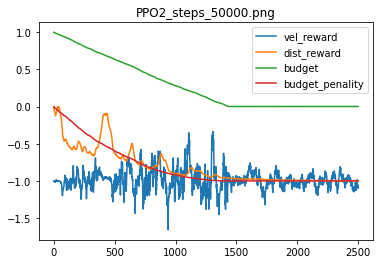

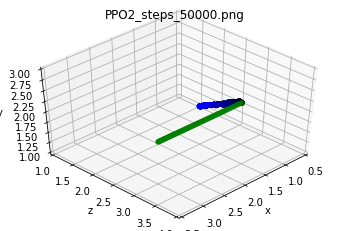

--------------------------------------
| approxkl           | 6.7427995e-05 |
| clipfrac           | 0.0           |
| explained_variance | 2.94e-05      |
| fps                | 92            |
| n_updates          | 1             |
| policy_entropy     | 1.4197083     |
| policy_loss        | 4.4771456e-05 |
| serial_timesteps   | 128           |
| time_elapsed       | 3.55e-05      |
| total_timesteps    | 61440         |
| value_loss         | 654.4252      |
--------------------------------------


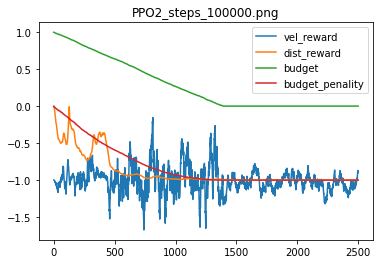

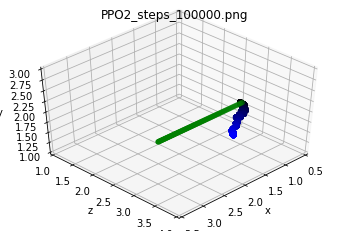

---------------------------------------
| approxkl           | 0.00019808787  |
| clipfrac           | 0.0            |
| explained_variance | -7.51e-06      |
| fps                | 93             |
| n_updates          | 1              |
| policy_entropy     | 1.4186236      |
| policy_loss        | -4.8234833e-05 |
| serial_timesteps   | 128            |
| time_elapsed       | 4.48e-05       |
| total_timesteps    | 107520         |
| value_loss         | 898.3653       |
---------------------------------------


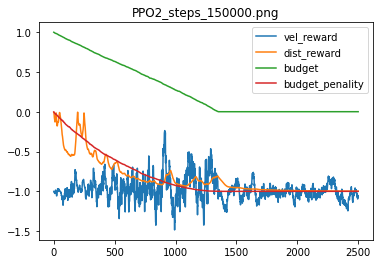

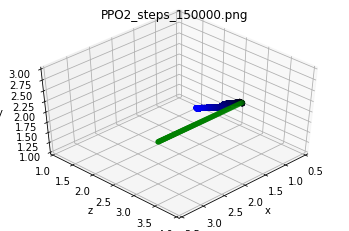

--------------------------------------
| approxkl           | 0.00018328178 |
| clipfrac           | 0.0           |
| explained_variance | -8.24e-05     |
| fps                | 93            |
| n_updates          | 1             |
| policy_entropy     | 1.4256854     |
| policy_loss        | 9.818114e-05  |
| serial_timesteps   | 128           |
| time_elapsed       | 4.6e-05       |
| total_timesteps    | 153600        |
| value_loss         | 1055.1606     |
--------------------------------------


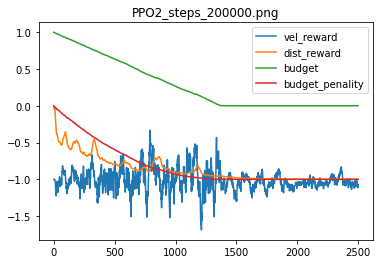

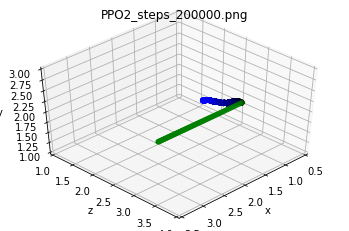

---------------------------------------
| approxkl           | 6.982014e-05   |
| clipfrac           | 0.0            |
| explained_variance | 2.92e-06       |
| fps                | 93             |
| n_updates          | 1              |
| policy_entropy     | 1.4338027      |
| policy_loss        | -2.1556776e-05 |
| serial_timesteps   | 128            |
| time_elapsed       | 4.36e-05       |
| total_timesteps    | 199680         |
| value_loss         | 1150.203       |
---------------------------------------


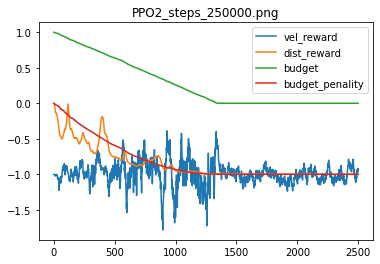

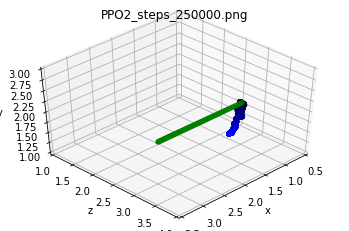

---------------------------------------
| approxkl           | 0.0012694453   |
| clipfrac           | 0.001936849    |
| explained_variance | 4.17e-07       |
| fps                | 94             |
| n_updates          | 1              |
| policy_entropy     | 1.4396834      |
| policy_loss        | -0.00023573863 |
| serial_timesteps   | 128            |
| time_elapsed       | 3.84e-05       |
| total_timesteps    | 245760         |
| value_loss         | 1171.0356      |
---------------------------------------


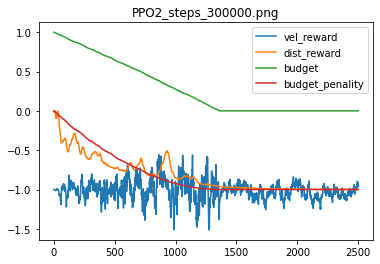

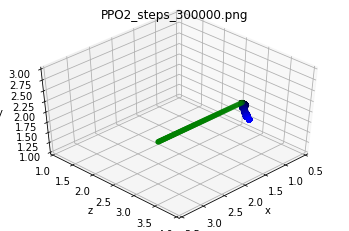

---------------------------------------
| approxkl           | 0.000117799995 |
| clipfrac           | 0.0            |
| explained_variance | 0              |
| fps                | 78             |
| n_updates          | 1              |
| policy_entropy     | 1.4404368      |
| policy_loss        | -4.2604297e-06 |
| serial_timesteps   | 128            |
| time_elapsed       | 4.63e-05       |
| total_timesteps    | 291840         |
| value_loss         | 1183.3209      |
---------------------------------------


In [ ]:
timesteps = int(2e7)
step = int(5e4)
length =int(timesteps/step) 
last_best_reward = -1e5
for i in range(1,length):
    model.learn(total_timesteps=step, log_interval=10, reset_num_timesteps=False)
    model.save(network_folder+algofoler+'models/'+"_steps_{0}".format(i*step))
    img_name =algo+ "_steps_{0}.png".format(i*step)
    rr = evaluate_env(env_test,model,title=img_name,traj_fig_name=network_folder+algofoler+'imgs/trajs/'+img_name,reward_fig_name=network_folder+algofoler+'imgs/rewards/'+img_name)
    if rr>last_best_reward:
        last_best_reward=rr
        model.save(network_folder+algofoler+'models/best')